## 06 Preparing the variables

After I built the dataset of press releases and coded every release for its content (immigration/not immigration), I can use this data to create a monthly indicator of mainstream parties' attention to immigration and merge this with monthly data of electoral polls and GoogleTrend Data of the public interest regarding immigration.

First, I import a dataset of all German polls including the AfD taken from the poll of polls API, which is currently only availale in R (https://github.com/petres/pollofpolls). I create a datetime variable to indicate the month of the poll, index the polling data with it and take the average for each month:

C:\Users\samunico\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


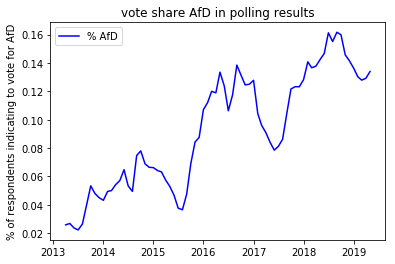

In [1]:
import pandas as pd
import os.path
from pandas import DataFrame as df
import matplotlib.pyplot as plt
%matplotlib inline


basedir = os.path.expanduser('~/Dropbox/Studies/Semester 2/Block I/data_IMEM/')

#%% variable: AfD success
afd = df.dropna(pd.read_csv(basedir+'afd_polls.csv'))
afd = afd.drop('Unnamed: 0', axis=1)


afd['monthyear'] = afd.date.str.slice(3,10,1)
afd['date'] = pd.to_datetime(afd.monthyear, format='%m/%Y')

afd = afd.groupby(['date']).mean()

# plot
plt.figure(figsize=(6,4))
plt.title("vote share AfD in polling results")
plt.plot(afd, label='% AfD', color = 'blue')
plt.legend(loc='upper left')
plt.ylabel('% of respondents indicating to vote for AfD')
plt.savefig(basedir+'afd.svg')
plt.show()

Similarly for my new dataset, I create a variable for the SPD, the CDU/CSU and overall mainstream party communication on immigration:

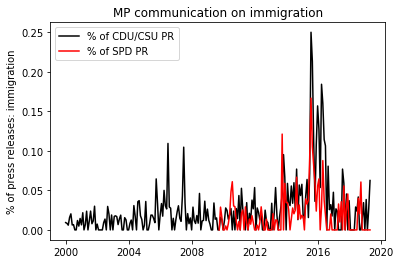

In [18]:
#%% variable: MP communication on immigration
mpc = pd.read_csv(basedir+'final_dataset.csv')
mpc = mpc[['date', 'coding', 'sender']]

mpc['monthyear'] = mpc.date.str.slice(3,10,1)
mpc['date'] = pd.to_datetime(mpc.monthyear, format='%m/%Y')

mpc_c = mpc.groupby(['date']).mean()
mpc_c['spd'] = mpc[mpc.sender == 'SPD'].groupby(['date']).mean()
mpc_c['cdu'] = mpc[mpc.sender == 'CDU'].groupby(['date']).mean()

# plot party communication alone
plt.figure(figsize=(6,4))
plt.title("MP communication on immigration")
plt.plot(mpc_c.cdu, label='% of CDU/CSU PR', color = 'black')
plt.plot(mpc_c.spd, label='% of SPD PR', color = 'red')
plt.legend(loc='upper left')
plt.ylabel('% of press releases: immigration')
plt.savefig(basedir+'mpimm.svg')
plt.show()

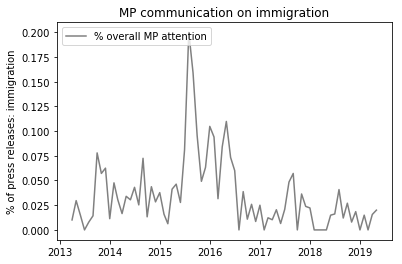

In [20]:
# plot party communication alone
plt.figure(figsize=(6,4))
plt.title("MP communication on immigration")
#plt.plot(mpc_c.cdu[(mpc_c.index >= "2013-04-01")], label='% of CDU/CSU PR', color = 'black')
#plt.plot(mpc_c.spd[(mpc_c.index >= "2013-04-01")], label='% of SPD PR', color = 'red')
plt.plot(mpc_c.coding[(mpc_c.index >= "2013-04-01")], label='% overall MP attention', color = 'grey')
plt.legend(loc='upper left')
plt.ylabel('% of press releases: immigration')
plt.savefig(basedir+'mpimm.svg')
plt.show()

And finally, for the GoogleTrend-data (which is already in the correct monthly form):

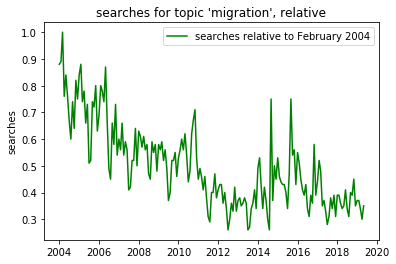

In [7]:
#%% var: google-trend
trend = pd.read_csv(basedir+'multiTimeline.csv')
trend = trend[1:]
trend['salience'] = pd.to_numeric(trend['Kategorie: Alle Kategorien'])/100
trend = trend.set_index(pd.to_datetime(trend.index, format='%Y-%m'))

# plot
plt.figure(figsize=(6,4))
plt.title("searches for topic 'migration', relative")
plt.plot(trend['salience'], label='searches relative to February 2004', color = 'green')
plt.legend(loc='upper right')
plt.ylabel('searches')
plt.savefig(basedir+'googleTrend.svg')
plt.show()

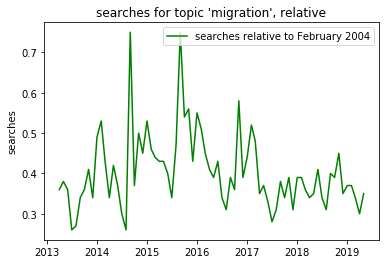

           Kategorie: Alle Kategorien  salience
2004-12-01                         75      0.75
2014-09-01                         75      0.75
2015-09-01                         75      0.75


In [17]:
# plot
plt.figure(figsize=(6,4))
plt.title("searches for topic 'migration', relative")
plt.plot(trend['salience'][(trend.index >= "2013-04-01")], label='searches relative to February 2004', color = 'green')
plt.legend(loc='upper right')
plt.ylabel('searches')
plt.savefig(basedir+'googleTrend.svg')
plt.show()

I bind the data to create a single csv file that can be used to estimate a time series:

C:\Users\samunico\Anaconda3\lib\site-packages\matplotlib\legend.py:508: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


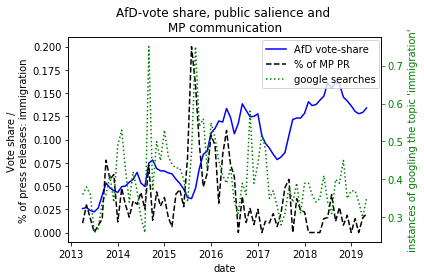

In [4]:
# bind
data = df.dropna(pd.concat([afd, mpc_c, trend['salience']], axis=1, sort = True))

# export
data.to_csv(basedir+'full_ts.csv')

# plot
fig, ax1 = plt.subplots()

ax1.plot(data.afd, label='AfD vote-share', color = 'blue')
ax1.plot(data.coding, label='% of MP PR', color = 'black', linestyle = '--')
ax1.set_xlabel('date')
ax1.set_ylabel('Vote share / \n% of press releases: immigration', color='black')
ax1.tick_params('y', colors='black')

ax2 = ax1.twinx()
ax2.plot(data.salience, label='google searches', color = 'green', linestyle = ':')
ax2.set_ylabel("instances of googling the topic 'immigration'", color='green')
ax2.tick_params('y', colors='green')

plt.title("AfD-vote share, public salience and \nMP communication")
fig.tight_layout()

fig.legend(loc = 'best', bbox_to_anchor=(0.89, 0.85))

fig.savefig(basedir+'full.svg')
plt.show()